https://ieeexplore.ieee.org/document/10423448

https://figshare.com/articles/dataset/Multiclass_Weeds_Dataset_for_Image_Segmentation/22643434?file=40195219


https://drive.google.com/file/d/1Ihjzt59qzBmI6JbBgJZpZyTg1wjZvKnE/view?usp=sharing


In [ ]:
! rm -rf dataset.zip

In [1]:
! gdown --id 1Ihjzt59qzBmI6JbBgJZpZyTg1wjZvKnE -O dataset.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Ihjzt59qzBmI6JbBgJZpZyTg1wjZvKnE
From (redirected): https://drive.google.com/uc?id=1Ihjzt59qzBmI6JbBgJZpZyTg1wjZvKnE&confirm=t&uuid=9e2c1495-0665-445e-a808-3953f1a8c60f
To: /content/dataset.zip
100% 707M/707M [00:11<00:00, 60.0MB/s]


In [2]:
! unzip -qq dataset.zip

In [3]:
! ls weed_augmented/images/* | wc

   7872    7872  259776


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from tqdm import tqdm

### Creating the train-val-test split, with 60% of the dataset for training, 10% of the dataset for validation and 30% of the dataset for testing; also resizing the images to 256x256 size before creating the dataset

In [5]:
# Configuration
source_folder = 'weed_augmented'
output_folder = '.'
random.seed(42)


# Create directories
dirs = ['train_images', 'train_masks', 'val_images', 'val_masks', 'test_images', 'test_masks']
for dir_name in dirs:
    os.makedirs(os.path.join(output_folder, dir_name), exist_ok=True)

# Get matching image-mask pairs
images_path = os.path.join(source_folder, 'images')
masks_path = os.path.join(source_folder, 'masks')

image_files = [f for f in os.listdir(images_path) if f.lower().endswith('.jpg')]
pairs = []

for img_file in image_files:
    mask_file = img_file.replace('.jpg', '.png')
    if os.path.exists(os.path.join(masks_path, mask_file)):
        pairs.append((img_file, mask_file))

print(f"Found {len(pairs)} matching image-mask pairs")

# Shuffle and split
random.shuffle(pairs)
n_total = len(pairs)
n_train = int(n_total * 0.6)
n_val = int(n_total * 0.1)

train_pairs = pairs[:n_train]
val_pairs = pairs[n_train:n_train + n_val]
test_pairs = pairs[n_train + n_val:]

print(f"Split: Train={len(train_pairs)}, Val={len(val_pairs)}, Test={len(test_pairs)}")


# Process and resize images
target_size = (256, 256)

for pairs_list, split_name in [(train_pairs, 'train'), (val_pairs, 'val'), (test_pairs, 'test')]:
    for img_file, mask_file_name in tqdm(pairs_list):
        # Load and resize image
        img = cv2.imread(os.path.join(images_path, img_file))
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)

        # Load and resize mask
        mask = cv2.imread(os.path.join(masks_path, mask_file_name))
        mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

        # Save resized images
        cv2.imwrite(os.path.join(output_folder, f'{split_name}_images', mask_file_name), img_resized)
        cv2.imwrite(os.path.join(output_folder, f'{split_name}_masks', mask_file_name), mask_resized)




Found 7872 matching image-mask pairs
Split: Train=4723, Val=787, Test=2362


100%|██████████| 2362/2362 [00:29<00:00, 79.51it/s]


### Creating overlays of the masks with the images, and showing first 5 samples from each of the train, validation and test splits

Most common mask colors (RGB):
  (np.uint8(0), np.uint8(0), np.uint8(0))
  (np.uint8(128), np.uint8(0), np.uint8(0))
  (np.uint8(0), np.uint8(128), np.uint8(0))


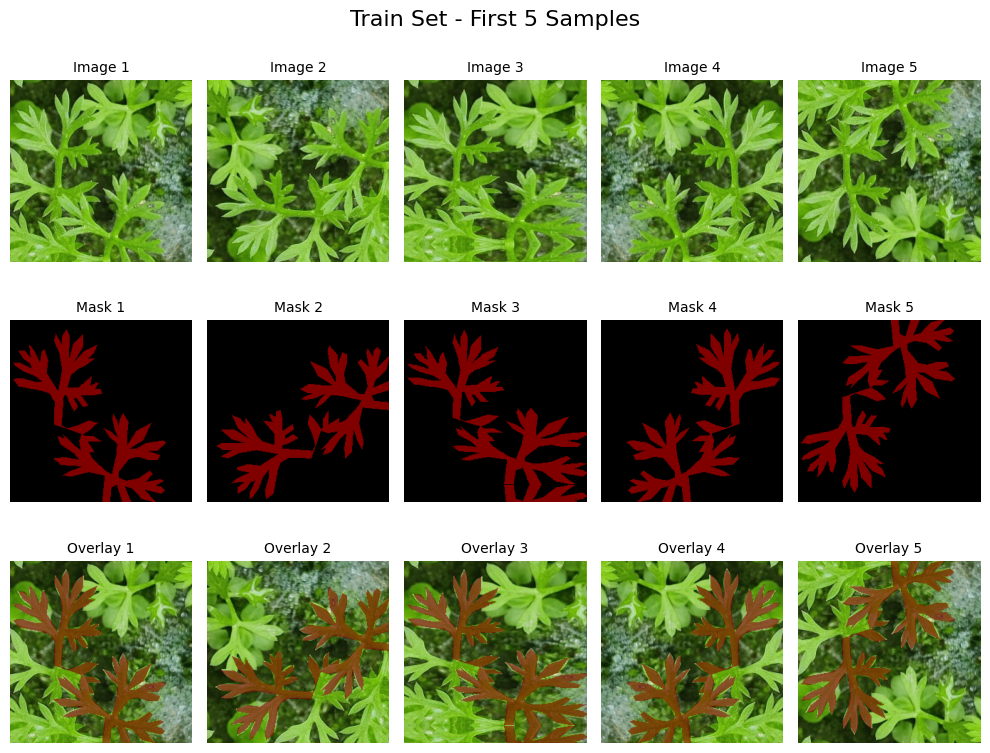

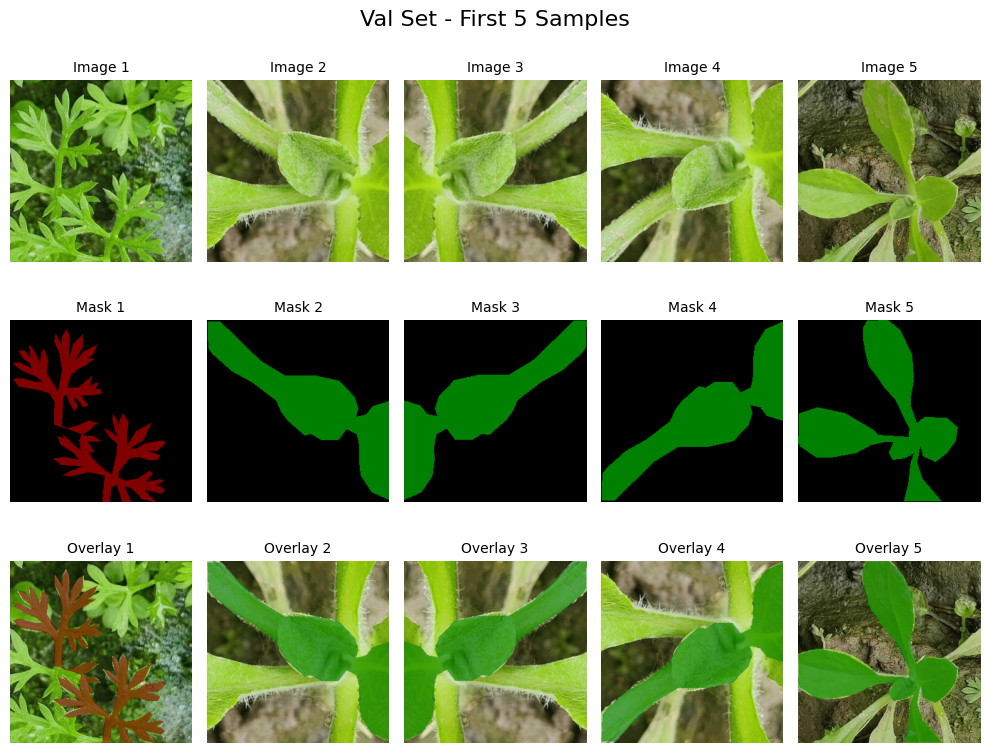

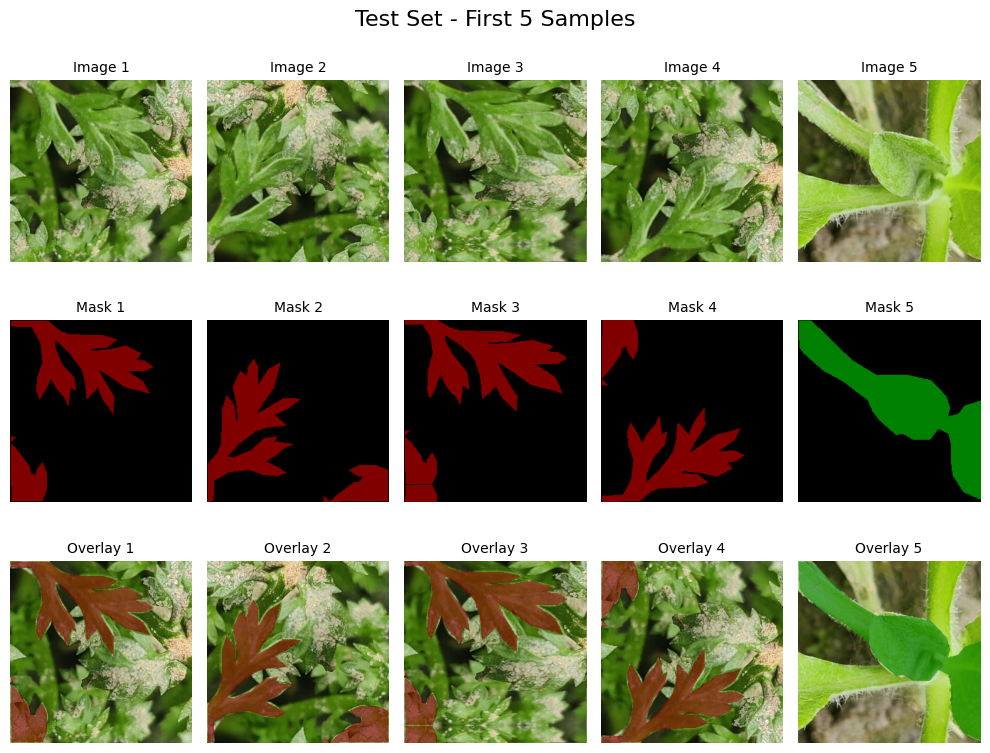

Dataset organized in '.' folder


In [6]:

# Analyze mask colors
mask_folder = os.path.join(output_folder, 'train_masks')
mask_files = [f for f in os.listdir(mask_folder) if f.lower().endswith('.png')]
sample_files = random.sample(mask_files, min(20, len(mask_files)))

all_colors = []
for filename in sample_files:
    mask = cv2.imread(os.path.join(mask_folder, filename))
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    unique_colors = np.unique(mask_rgb.reshape(-1, 3), axis=0)
    all_colors.extend([tuple(color) for color in unique_colors])

color_counts = Counter(all_colors)
class_colors = [color for color, _ in color_counts.most_common(10)]

print("Most common mask colors (RGB):")
for color in class_colors[:5]:
    print(f"  {color}")

# Visualize samples
def create_overlay(image, mask, colors, alpha=0.6):
    overlay = image.copy()
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    for color in colors:
        if color == (0, 0, 0):
            continue
        color_mask = np.all(mask_rgb == color, axis=2)
        if np.any(color_mask):
            overlay[color_mask] = (alpha * np.array(color) + (1 - alpha) * overlay[color_mask]).astype(np.uint8)
    return overlay

# Show samples for each split
for split in ['train', 'val', 'test']:
    img_folder = os.path.join(output_folder, f'{split}_images')
    mask_folder = os.path.join(output_folder, f'{split}_masks')

    img_files = sorted([f for f in os.listdir(img_folder) if f.lower().endswith('.png')])[:5]

    if not img_files:
        continue

    fig, axes = plt.subplots(3, len(img_files), figsize=(10, 8))
    fig.suptitle(f'{split.capitalize()} Set - First {len(img_files)} Samples', fontsize=16)

    for i, img_file in enumerate(img_files):
        mask_file = img_file

        img = cv2.imread(os.path.join(img_folder, img_file))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(mask_folder, mask_file))
        mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        overlay = create_overlay(img_rgb, mask, class_colors)

        axes[0, i].imshow(img_rgb)
        axes[0, i].set_title(f'Image {i+1}', fontsize=10)
        axes[0, i].axis('off')

        axes[1, i].imshow(mask_rgb)
        axes[1, i].set_title(f'Mask {i+1}', fontsize=10)
        axes[1, i].axis('off')

        axes[2, i].imshow(overlay)
        axes[2, i].set_title(f'Overlay {i+1}', fontsize=10)
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

print(f"Dataset organized in '{output_folder}' folder")

In [7]:
! pip install colorama

In [8]:
# Make sure you have all the necessary imports at the top
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
import glob
from pathlib import Path
from tqdm import tqdm
from colorama import Fore, Style

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paste all your code here (the modified version from the artifact)

Using device: cpu


In [12]:
# Use the data generator to load the dataset
class DataGenerator(Dataset):
    def __init__(self, image_list, masks_folder, num_classes=3):
        self.files = image_list
        self.masks_folder = masks_folder
        self.num_classes = num_classes

    # NUMBER OF FILES IN THE DATASET
    def __len__(self):
        return len(self.files)

    # GETTING SINGLE PAIR OF DATA
    def __getitem__(self, idx):
        file_name = self.files[idx].split('/')[-1]
        file_name = file_name[:-4]

        mask_name = './{}/'.format(self.masks_folder) + file_name + '.png'

        img = cv2.imread(self.files[idx], cv2.IMREAD_UNCHANGED)
        if len(img.shape) == 2:
            img = cv2.merge((img, img, img))

        # Read mask as 3-channel for multi-class
        mask = cv2.imread(mask_name, cv2.IMREAD_COLOR)  # Read as BGR
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)     # Convert to RGB

        # Transpose image and mask
        img_transpose = np.transpose(img, (2, 0, 1))
        mask_transpose = np.transpose(mask, (2, 0, 1))

        # Normalize image to [0, 1]
        img_normalized = img_transpose / 255.0
        # Normalize mask to [0, 1] for each channel
        mask_normalized = mask_transpose / 255.0

        return torch.FloatTensor(img_normalized), torch.FloatTensor(mask_normalized), str(file_name)


def load_data(image_list, masks_folder, batch_size=2, num_workers=10, shuffle=True, num_classes=3):
    dataset = DataGenerator(image_list, masks_folder=masks_folder, num_classes=num_classes)
    data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    return data_loader


# Dice coefficient calculation for multi-class
def dice_coefficient(pred, target, num_classes, smooth=1e-6):
    """
    Calculate dice coefficient for multi-class segmentation
    pred: predicted probabilities [B, C, H, W]
    target: ground truth [B, C, H, W]
    """
    dice_scores = []

    for class_idx in range(num_classes):
        pred_class = pred[:, class_idx, :, :]
        target_class = target[:, class_idx, :, :]

        intersection = (pred_class * target_class).sum(dim=(1, 2))
        union = pred_class.sum(dim=(1, 2)) + target_class.sum(dim=(1, 2))

        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.mean())

    return torch.stack(dice_scores), torch.stack(dice_scores).mean()


# IoU calculation for multi-class
def iou_coefficient(pred, target, num_classes, smooth=1e-6):
    """
    Calculate IoU for multi-class segmentation
    pred: predicted probabilities [B, C, H, W]
    target: ground truth [B, C, H, W]
    """
    iou_scores = []

    for class_idx in range(num_classes):
        pred_class = pred[:, class_idx, :, :]
        target_class = target[:, class_idx, :, :]

        intersection = (pred_class * target_class).sum(dim=(1, 2))
        union = pred_class.sum(dim=(1, 2)) + target_class.sum(dim=(1, 2)) - intersection

        iou = (intersection + smooth) / (union + smooth)
        iou_scores.append(iou.mean())

    return torch.stack(iou_scores), torch.stack(iou_scores).mean()


# Multi-class Dice Loss
class MultiClassDiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-6):
        super(MultiClassDiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, pred, target):
        total_loss = 0

        for class_idx in range(self.num_classes):
            pred_class = pred[:, class_idx, :, :]
            target_class = target[:, class_idx, :, :]

            intersection = (pred_class * target_class).sum(dim=(1, 2))
            union = pred_class.sum(dim=(1, 2)) + target_class.sum(dim=(1, 2))

            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_loss = 1 - dice.mean()
            total_loss += dice_loss

        return total_loss / self.num_classes


# Combined loss function
class CombinedLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = MultiClassDiceLoss(num_classes)
        self.ce_loss = nn.BCELoss()  # Since we're using sigmoid/softmax output
        self.alpha = alpha

    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        ce = self.ce_loss(pred, target)
        return self.alpha * dice + (1 - self.alpha) * ce


# sanity check
def get_image_address(image_data_folder, subfolder_name):
    total_imgs = glob.glob(image_data_folder+subfolder_name+"/*.png")
    error_counter = 0
    TOTAL_COUNT = len(total_imgs)
    image_address_list = []
    for image_name in total_imgs:
        try:
            img = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
            x = img.shape
            image_address_list.append(image_name)
        except:
            print("Image not found : ",image_name)
            error_counter+=1
    print("Number of Files not found : ", error_counter)
    print("Total Number of Files found : ", len(image_address_list))
    return image_address_list


# save checkpoint in pytorch
def save_ckp(checkpoint, checkpoint_path, save_after_epochs):
    if checkpoint['epoch'] % save_after_epochs == 0:
        torch.save(checkpoint, checkpoint_path)


# load checkpoint in pytorch
def load_ckp(checkpoint_path, model, model_opt):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model_opt.load_state_dict(checkpoint['optimizer'])
    return model, model_opt, checkpoint['epoch']


def train_epoch(train_loader, model, optimizer, epoch, hist_folder_name, num_classes=3):
    print("\n\n---------------------------------------------------------------------------------------------------------------\n")

    progress_bar = tqdm(enumerate(train_loader))
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0

    model.train()
    for step, (inp__, gt__, file_name) in progress_bar:
        #TRANSFERRING DATA TO DEVICE
        inp__ = inp__.to(device)
        gt__ = gt__.to(device)

        # clear the gradient
        optimizer.zero_grad()

        #GETTING THE PREDICTED IMAGE
        pred_img = model.forward(inp__)

        #LOSS FUNCTIONS
        criterion = CombinedLoss(num_classes=num_classes, alpha=0.7)

        #CALCULATING LOSSES
        loss = criterion(pred_img, gt__)

        #LOSS TAKEN INTO CONSIDERATION
        total_loss += loss.item()

        # Calculate metrics
        with torch.no_grad():
            dice_per_class, mean_dice = dice_coefficient(pred_img, gt__, num_classes)
            iou_per_class, mean_iou = iou_coefficient(pred_img, gt__, num_classes)
            total_dice += mean_dice.item()
            total_iou += mean_iou.item()

        #BACKPROPAGATING THE LOSS
        loss.backward()
        optimizer.step()

        #DISPLAYING THE LOSS
        progress_bar.set_description("Epoch: {} - Loss: {:.4f} - Dice: {:.4f} - IoU: {:.4f}".format(
            epoch, loss.item(), mean_dice.item(), mean_iou.item()))

    avg_loss = total_loss / len(train_loader)
    avg_dice = total_dice / len(train_loader)
    avg_iou = total_iou / len(train_loader)

    with open("{}/train_logs.txt".format(hist_folder_name), "a") as text_file:
        text_file.write("{} {:.6f} {:.6f} {:.6f}\n".format(epoch, avg_loss, avg_dice, avg_iou))

    print(Fore.GREEN+"Training Epoch: {} | Loss: {:.4f} | Dice: {:.4f} | IoU: {:.4f}".format(
        epoch, avg_loss, avg_dice, avg_iou)+Style.RESET_ALL)

    return model, optimizer


def val_epoch(val_loader, model, optimizer, epoch, hist_folder_name, num_classes=3):
    model.eval()
    progress_bar = tqdm(enumerate(val_loader))
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0

    criterion = CombinedLoss(num_classes=num_classes, alpha=0.7)

    for step, (inp__, gt__, file_name) in progress_bar:
        inp__ = inp__.to(device)
        gt__ = gt__.to(device)

        #PREDICTED IMAGE
        pred_img = model.forward(inp__)

        #CALCULATING LOSSES
        loss = criterion(pred_img, gt__)
        total_loss += loss.item()

        # Calculate metrics
        dice_per_class, mean_dice = dice_coefficient(pred_img, gt__, num_classes)
        iou_per_class, mean_iou = iou_coefficient(pred_img, gt__, num_classes)
        total_dice += mean_dice.item()
        total_iou += mean_iou.item()

        progress_bar.set_description("Val Epoch: {} - Loss: {:.4f} - Dice: {:.4f} - IoU: {:.4f}".format(
            epoch, loss.item(), mean_dice.item(), mean_iou.item()))

    avg_loss = total_loss / len(val_loader)
    avg_dice = total_dice / len(val_loader)
    avg_iou = total_iou / len(val_loader)

    with open("{}/val_logs.txt".format(hist_folder_name), "a") as text_file:
        text_file.write("{} {:.6f} {:.6f} {:.6f}\n".format(epoch, avg_loss, avg_dice, avg_iou))

    print(Fore.BLUE+"Validation Epoch: {} | Loss: {:.4f} | Dice: {:.4f} | IoU: {:.4f}".format(
        epoch, avg_loss, avg_dice, avg_iou)+Style.RESET_ALL)


def test_epoch(test_loader, model, optimizer, epoch, inf_folder_name, hist_folder_name, num_classes=3):
    model.eval()
    progress_bar = tqdm(enumerate(test_loader))
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0

    #SETTING THE NUMBER OF IMAGES TO CHECK AFTER EACH ITERATION
    no_img_to_write = 20

    criterion = CombinedLoss(num_classes=num_classes, alpha=0.7)

    for step, (inp__, gt__, file_name) in progress_bar:
        inp__ = inp__.to(device)
        gt__ = gt__.to(device)

        #PREDICTED IMAGE
        pred_img = model.forward(inp__)

        #CALCULATING LOSSES
        loss = criterion(pred_img, gt__)
        total_loss += loss.item()

        # Calculate metrics
        dice_per_class, mean_dice = dice_coefficient(pred_img, gt__, num_classes)
        iou_per_class, mean_iou = iou_coefficient(pred_img, gt__, num_classes)
        total_dice += mean_dice.item()
        total_iou += mean_iou.item()

        progress_bar.set_description("Test Epoch: {} - Loss: {:.4f} - Dice: {:.4f} - IoU: {:.4f}".format(
            epoch, loss.item(), mean_dice.item(), mean_iou.item()))

        #WRITING THE IMAGES INTO THE SPECIFIED DIRECTORY
        if(step < no_img_to_write):

            p_img = pred_img.cpu().numpy()
            gt_img = gt__.cpu().numpy()
            inp_img = inp__.cpu().numpy()

            #FOLDER PATH TO WRITE THE INFERENCES
            inference_folder = "{}".format(inf_folder_name)
            if not os.path.isdir(inference_folder):
                os.mkdir(inference_folder)

            print("\n Saving inferences at epoch === ",epoch)

            # Save inference images for multi-class
            for batch_idx, (p_image_loop, gt_img_loop, inp_img_loop) in enumerate(zip(p_img, gt_img, inp_img)):
                # Convert predictions to class predictions (argmax for visualization)
                p_image_class = np.argmax(p_image_loop, axis=0)  # [H, W]
                p_image_class = (p_image_class * 255 / (num_classes - 1)).astype(np.uint8)  # Scale to 0-255
                cv2.imwrite(os.path.join(inference_folder, str(file_name[batch_idx])+"_pred_class.png"), p_image_class)

                # Save each channel of prediction separately
                for ch in range(num_classes):
                    p_channel = (p_image_loop[ch] * 255.0).astype(np.uint8)
                    cv2.imwrite(os.path.join(inference_folder, str(file_name[batch_idx])+f"_pred_ch{ch}.png"), p_channel)

                # Save ground truth
                gt_image_class = np.argmax(gt_img_loop, axis=0)  # [H, W]
                gt_image_class = (gt_image_class * 255 / (num_classes - 1)).astype(np.uint8)  # Scale to 0-255
                cv2.imwrite(os.path.join(inference_folder, str(file_name[batch_idx])+"_gt_class.png"), gt_image_class)

                # Save input image
                inp_img_loop = np.transpose(inp_img_loop, (1, 2, 0))
                inp_img_loop = (inp_img_loop * 255.0).astype(np.uint8)
                cv2.imwrite(os.path.join(inference_folder, str(file_name[batch_idx])+"_img.png"), inp_img_loop)

    avg_loss = total_loss / len(test_loader)
    avg_dice = total_dice / len(test_loader)
    avg_iou = total_iou / len(test_loader)

    with open("{}/test_logs.txt".format(hist_folder_name), "a") as text_file:
        text_file.write("{} {:.6f} {:.6f} {:.6f}\n".format(epoch, avg_loss, avg_dice, avg_iou))

    print(Fore.RED+"Test Epoch: {} | Loss: {:.4f} | Dice: {:.4f} | IoU: {:.4f}".format(
        epoch, avg_loss, avg_dice, avg_iou)+Style.RESET_ALL)
    print("---------------------------------------------------------------------------------------------------------------")


def train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume, model_name, inf_folder_name, hist_folder_name, save_after_epochs, num_classes=3):

    Path(inf_folder_name).mkdir(parents=True, exist_ok=True)
    Path(hist_folder_name).mkdir(parents=True, exist_ok=True)

    epoch = 0

    #PATH TO SAVE THE CHECKPOINT
    checkpoint_path = "checkpoint/{}_{}.pt".format(model_name,epoch)

    #IF TRAINING IS TO RESUMED FROM A CERTAIN CHECKPOINT
    if resume:
        model, optimizer, epoch = load_ckp(
            checkpoint_path, model, optimizer)

    while epoch <= n_epoch:
        checkpoint_path = "checkpoint/{}_{}.pt".format(model_name,epoch)
        epoch += 1
        model, optimizer = train_epoch(train_loader, model, optimizer, epoch, hist_folder_name, num_classes)

        #CHECKPOINT CREATION
        checkpoint = {'epoch': epoch+1, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict()}

        #CHECKPOINT SAVING
        save_ckp(checkpoint, checkpoint_path, save_after_epochs)
        print(Fore.BLACK+"Checkpoint Saved"+Style.RESET_ALL)

        with torch.no_grad():
            val_epoch(val_loader, model, optimizer, epoch, hist_folder_name, num_classes)

    print("************************ Final Test Epoch *****************************")

    with torch.no_grad():
        test_epoch(test_loader, model, optimizer, epoch, inf_folder_name, hist_folder_name, num_classes)


def main():
    # Set your parameters directly here for Jupyter notebook
    class Args:
        def __init__(self):
            # Training parameters
            self.lr = "0.001"
            self.batch_size = "4"
            self.num_epochs = "10"
            self.num_classes = 3

            # Dataset folders
            self.train_images = "train_images"
            self.val_images = "val_images"
            self.test_images = "test_images"

            self.train_masks = "train_masks"
            self.val_masks = "val_masks"
            self.test_masks = "test_masks"

            # Output folders
            self.history_folder_name = "history"
            self.inference_folder_name = "inference"
            self.chkpt_name = "multiclass_model"
            self.save_after_epoch = "10"

    args = Args()

    train_image_address_list = get_image_address("./", args.train_images)
    print("Total Number of Training Images : ", len(train_image_address_list))

    val_image_address_list = get_image_address("./", args.val_images)
    test_image_address_list = get_image_address("./", args.test_images)

    train_masks = args.train_masks
    val_masks = args.val_masks
    test_masks = args.test_masks
    save_after_epochs = int(args.save_after_epoch)
    num_classes = args.num_classes

    # CREATING THE TRAIN LOADER
    train_loader = load_data(
        train_image_address_list, masks_folder=train_masks, batch_size=int(args.batch_size),
        num_workers=8, shuffle=True, num_classes=num_classes)

    val_loader = load_data(
        val_image_address_list, masks_folder=val_masks, batch_size=int(args.batch_size),
        num_workers=8, shuffle=True, num_classes=num_classes)

    # CREATING THE TEST LOADER
    test_loader = load_data(
        test_image_address_list, masks_folder=test_masks, batch_size=1,
        num_workers=8, shuffle=False, num_classes=num_classes)

    # CALLING THE MODEL - Make sure your model outputs num_classes channels
    model = ResUnetPlusPlus(input_ch=3, n_class=num_classes)  # Change this to match your model
    model = nn.DataParallel(model)
    model = model.to(device)

    # DEFINING THE OPTIMIZER
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], lr=float(args.lr), weight_decay=5e-4)

    n_epoch = int(args.num_epochs)

    # INDICATOR VARIABLE TO RESUME TRAINING OR START AFRESH
    resume = False
    model_name = args.chkpt_name
    inf_folder_name = args.inference_folder_name
    hist_folder_name = args.history_folder_name

    train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume,
                   model_name, inf_folder_name, hist_folder_name, save_after_epochs, num_classes)

if __name__ == "__main__":
    main()

Image not found :  ./train_images/0168_1.png
Image not found :  ./train_images/1186_2.png
Number of Files not found :  2
Total Number of Files found :  4721
Total Number of Training Images :  4721
Number of Files not found :  0
Total Number of Files found :  787
Number of Files not found :  0
Total Number of Files found :  2362


---------------------------------------------------------------------------------------------------------------



0it [00:12, ?it/s]


KeyboardInterrupt: 

### Use the [ResUNet++](https://arxiv.org/pdf/1911.07067) model for image segmentation, which is very lightweight in itself.

In [10]:
# https://github.com/DebeshJha/ResUNetPlusPlus-with-CRF-and-TTA/blob/master/resunet%2B%2B_pytorch.py

# Note: This uses 3 channel input

import torch
import torch.nn as nn
import torch.nn.functional as F

class Squeeze_Excitation(nn.Module):
    def __init__(self, channel, r=8):
        super().__init__()

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.net = nn.Sequential(
            nn.Linear(channel, channel // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // r, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        b, c, _, _ = inputs.shape
        x = self.pool(inputs).view(b, c)
        x = self.net(x).view(b, c, 1, 1)
        x = inputs * x
        return x

class Stem_Block(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(out_c),
        )

        self.attn = Squeeze_Excitation(out_c)

    def forward(self, inputs):
        x = self.c1(inputs)
        s = self.c2(inputs)
        y = self.attn(x + s)
        return y

class ResNet_Block(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.ReLU(),
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(out_c),
        )

        self.attn = Squeeze_Excitation(out_c)

    def forward(self, inputs):
        x = self.c1(inputs)
        s = self.c2(inputs)
        y = self.attn(x + s)
        return y

class ASPP(nn.Module):
    def __init__(self, in_c, out_c, rate=[1, 6, 12, 18]):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[0], padding=rate[0]),
            nn.BatchNorm2d(out_c)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[1], padding=rate[1]),
            nn.BatchNorm2d(out_c)
        )

        self.c3 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[2], padding=rate[2]),
            nn.BatchNorm2d(out_c)
        )

        self.c4 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[3], padding=rate[3]),
            nn.BatchNorm2d(out_c)
        )

        self.c5 = nn.Conv2d(out_c, out_c, kernel_size=1, padding=0)


    def forward(self, inputs):
        x1 = self.c1(inputs)
        x2 = self.c2(inputs)
        x3 = self.c3(inputs)
        x4 = self.c4(inputs)
        x = x1 + x2 + x3 + x4
        y = self.c5(x)
        return y

class Attention_Block(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        out_c = in_c[1]

        self.g_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[0]),
            nn.ReLU(),
            nn.Conv2d(in_c[0], out_c, kernel_size=3, padding=1),
            nn.MaxPool2d((2, 2))
        )

        self.x_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[1]),
            nn.ReLU(),
            nn.Conv2d(in_c[1], out_c, kernel_size=3, padding=1),
        )

        self.gc_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[1]),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        )

    def forward(self, g, x):
        g_pool = self.g_conv(g)
        x_conv = self.x_conv(x)
        gc_sum = g_pool + x_conv
        gc_conv = self.gc_conv(gc_sum)
        y = gc_conv * x
        return y

class Decoder_Block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.a1 = Attention_Block(in_c)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.r1 = ResNet_Block(in_c[0]+in_c[1], out_c, stride=1)

    def forward(self, g, x):
        d = self.a1(g, x)
        d = self.up(d)
        d = torch.cat([d, g], axis=1)
        d = self.r1(d)
        return d

class ResUnetPlusPlus(nn.Module):
    def __init__(self, input_ch, n_class):
        super().__init__()

        self.num_classes = n_class

        self.c1 = Stem_Block(input_ch, 16, stride=1)
        self.c2 = ResNet_Block(16, 32, stride=2)
        self.c3 = ResNet_Block(32, 64, stride=2)
        self.c4 = ResNet_Block(64, 128, stride=2)

        self.b1 = ASPP(128, 256)

        self.d1 = Decoder_Block([64, 256], 128)
        self.d2 = Decoder_Block([32, 128], 64)
        self.d3 = Decoder_Block([16, 64], 32)

        self.aspp = ASPP(32, 16)
        self.output = nn.Conv2d(16, n_class, kernel_size=1, padding=0)

    def forward(self, inputs):
        c1 = self.c1(inputs)
        c2 = self.c2(c1)
        c3 = self.c3(c2)
        c4 = self.c4(c3)

        b1 = self.b1(c4)

        d1 = self.d1(c3, b1)
        d2 = self.d2(c2, d1)
        d3 = self.d3(c1, d2)

        output = self.aspp(d3)
        output = self.output(output)

        if self.num_classes == 1:
            output = torch.sigmoid(output)
        elif self.num_classes > 1:
            output = F.softmax(output, dim = 1)

        return output